In [2]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
import matplotlib.pyplot as plt

def dividir_documento_por_texto(image_path, palabras_clave):
    """
    Divide el documento detectando palabras clave específicas
    
    Parámetros:
    - palabras_clave: dict con keys 'fin_encabezado', 'fin_cuerpo'
    """
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # OCR para detectar texto y posiciones
    datos_ocr = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT, lang='spa')
    
    # Buscar posiciones de palabras clave
    posiciones = {}
    
    for palabra_clave, texto_buscar in palabras_clave.items():
        for i, texto in enumerate(datos_ocr['text']):
            if texto_buscar.lower() in texto.lower():
                y = datos_ocr['top'][i]
                posiciones[palabra_clave] = y
                print(f"'{texto_buscar}' encontrado en y={y}")
                break
    
    # Definir puntos de corte
    h, w = img.shape[:2]
    
    # Encabezado: desde arriba hasta "Asunto"
    y1 = posiciones.get('fin_encabezado', int(h * 0.15))
    
    # Cuerpo: desde "Asunto" hasta resultados
    y2 = posiciones.get('fin_cuerpo', int(h * 0.85))
    
    # Dividir imagen
    encabezado = img_rgb[0:y1, :]
    cuerpo = img_rgb[y1:y2, :]
    pie = img_rgb[y2:h, :]
    
    return {
        'encabezado': encabezado,
        'cuerpo': cuerpo,
        'pie': pie,
        'posiciones': {'y1': y1, 'y2': y2}
    }


def visualizar_division(image_path, palabras_clave):
    """
    Visualiza las 3 partes divididas
    """
    partes = dividir_documento_por_texto(image_path, palabras_clave)
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    
    # Original con líneas de división
    img_original = cv2.imread(image_path)
    img_con_lineas = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB).copy()
    
    y1 = partes['posiciones']['y1']
    y2 = partes['posiciones']['y2']
    
    cv2.line(img_con_lineas, (0, y1), (img_con_lineas.shape[1], y1), (255, 0, 0), 3)
    cv2.line(img_con_lineas, (0, y2), (img_con_lineas.shape[1], y2), (255, 0, 0), 3)
    
    axes[0].imshow(img_con_lineas)
    axes[0].set_title('Original\n(con divisiones)', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Las 3 partes
    axes[1].imshow(partes['encabezado'])
    axes[1].set_title(f'1. Encabezado\n(0 - {y1}px)', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(partes['cuerpo'])
    axes[2].set_title(f'2. Cuerpo\n({y1} - {y2}px)', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    axes[3].imshow(partes['pie'])
    axes[3].set_title(f'3. Pie\n({y2} - fin)', fontsize=12, fontweight='bold')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return partes

In [4]:
def dividir_por_densidad(image_path):
    """
    Divide el documento analizando la densidad de píxeles negros
    Más rápido, no necesita OCR
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Binarizar
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Calcular densidad horizontal (píxeles negros por fila)
    densidad_horizontal = np.sum(binary, axis=1)
    
    # Suavizar la señal
    from scipy.ndimage import gaussian_filter1d
    densidad_suavizada = gaussian_filter1d(densidad_horizontal, sigma=10)
    
    h, w = img.shape[:2]
    
    # Encontrar zonas de baja densidad (espacios entre secciones)
    umbral = np.mean(densidad_suavizada) * 0.3
    zonas_bajas = densidad_suavizada < umbral
    
    # Buscar primer gran espacio (después del encabezado)
    y1 = None
    contador = 0
    for i in range(int(h * 0.1), int(h * 0.3)):  # Buscar en primeros 30%
        if zonas_bajas[i]:
            contador += 1
            if contador > 20 and y1 is None:  # 20 filas consecutivas de espacio
                y1 = i - 10
                break
        else:
            contador = 0
    
    if y1 is None:
        y1 = int(h * 0.15)  # Valor por defecto
    
    # Buscar segundo espacio (antes del pie)
    y2 = None
    contador = 0
    for i in range(int(h * 0.7), int(h * 0.95)):  # Buscar en últimos 25%
        if zonas_bajas[i]:
            contador += 1
            if contador > 20 and y2 is None:
                y2 = i - 10
                break
        else:
            contador = 0
    
    if y2 is None:
        y2 = int(h * 0.85)  # Valor por defecto
    
    # Dividir
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return {
        'encabezado': img_rgb[0:y1, :],
        'cuerpo': img_rgb[y1:y2, :],
        'pie': img_rgb[y2:h, :],
        'posiciones': {'y1': y1, 'y2': y2},
        'densidad': densidad_suavizada
    }


def visualizar_division_densidad(image_path):
    """
    Visualiza división por densidad con gráfico
    """
    partes = dividir_por_densidad(image_path)
    
    fig = plt.figure(figsize=(20, 12))
    
    # Crear grid
    gs = fig.add_gridspec(2, 4, height_ratios=[1, 3])
    
    # Gráfico de densidad
    ax_densidad = fig.add_subplot(gs[0, :])
    ax_densidad.plot(partes['densidad'], linewidth=2, color='blue')
    ax_densidad.axhline(np.mean(partes['densidad']) * 0.3, 
                        color='red', linestyle='--', label='Umbral')
    ax_densidad.axvline(partes['posiciones']['y1'], color='green', 
                        linestyle='-', linewidth=2, label='División 1')
    ax_densidad.axvline(partes['posiciones']['y2'], color='orange', 
                        linestyle='-', linewidth=2, label='División 2')
    ax_densidad.set_title('Densidad de píxeles negros por fila', fontsize=14, fontweight='bold')
    ax_densidad.set_xlabel('Fila (píxeles)')
    ax_densidad.set_ylabel('Densidad')
    ax_densidad.legend()
    ax_densidad.grid(True, alpha=0.3)
    
    # Original con líneas
    img_original = cv2.imread(image_path)
    img_con_lineas = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB).copy()
    
    y1 = partes['posiciones']['y1']
    y2 = partes['posiciones']['y2']
    
    cv2.line(img_con_lineas, (0, y1), (img_con_lineas.shape[1], y1), (0, 255, 0), 4)
    cv2.line(img_con_lineas, (0, y2), (img_con_lineas.shape[1], y2), (255, 165, 0), 4)
    
    ax1 = fig.add_subplot(gs[1, 0])
    ax1.imshow(img_con_lineas)
    ax1.set_title('Original con divisiones', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Las 3 partes
    ax2 = fig.add_subplot(gs[1, 1])
    ax2.imshow(partes['encabezado'])
    ax2.set_title(f'Encabezado\n(0-{y1})', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.imshow(partes['cuerpo'])
    ax3.set_title(f'Cuerpo\n({y1}-{y2})', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[1, 3])
    ax4.imshow(partes['pie'])
    ax4.set_title(f'Pie\n({y2}-fin)', fontsize=12, fontweight='bold')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return partes

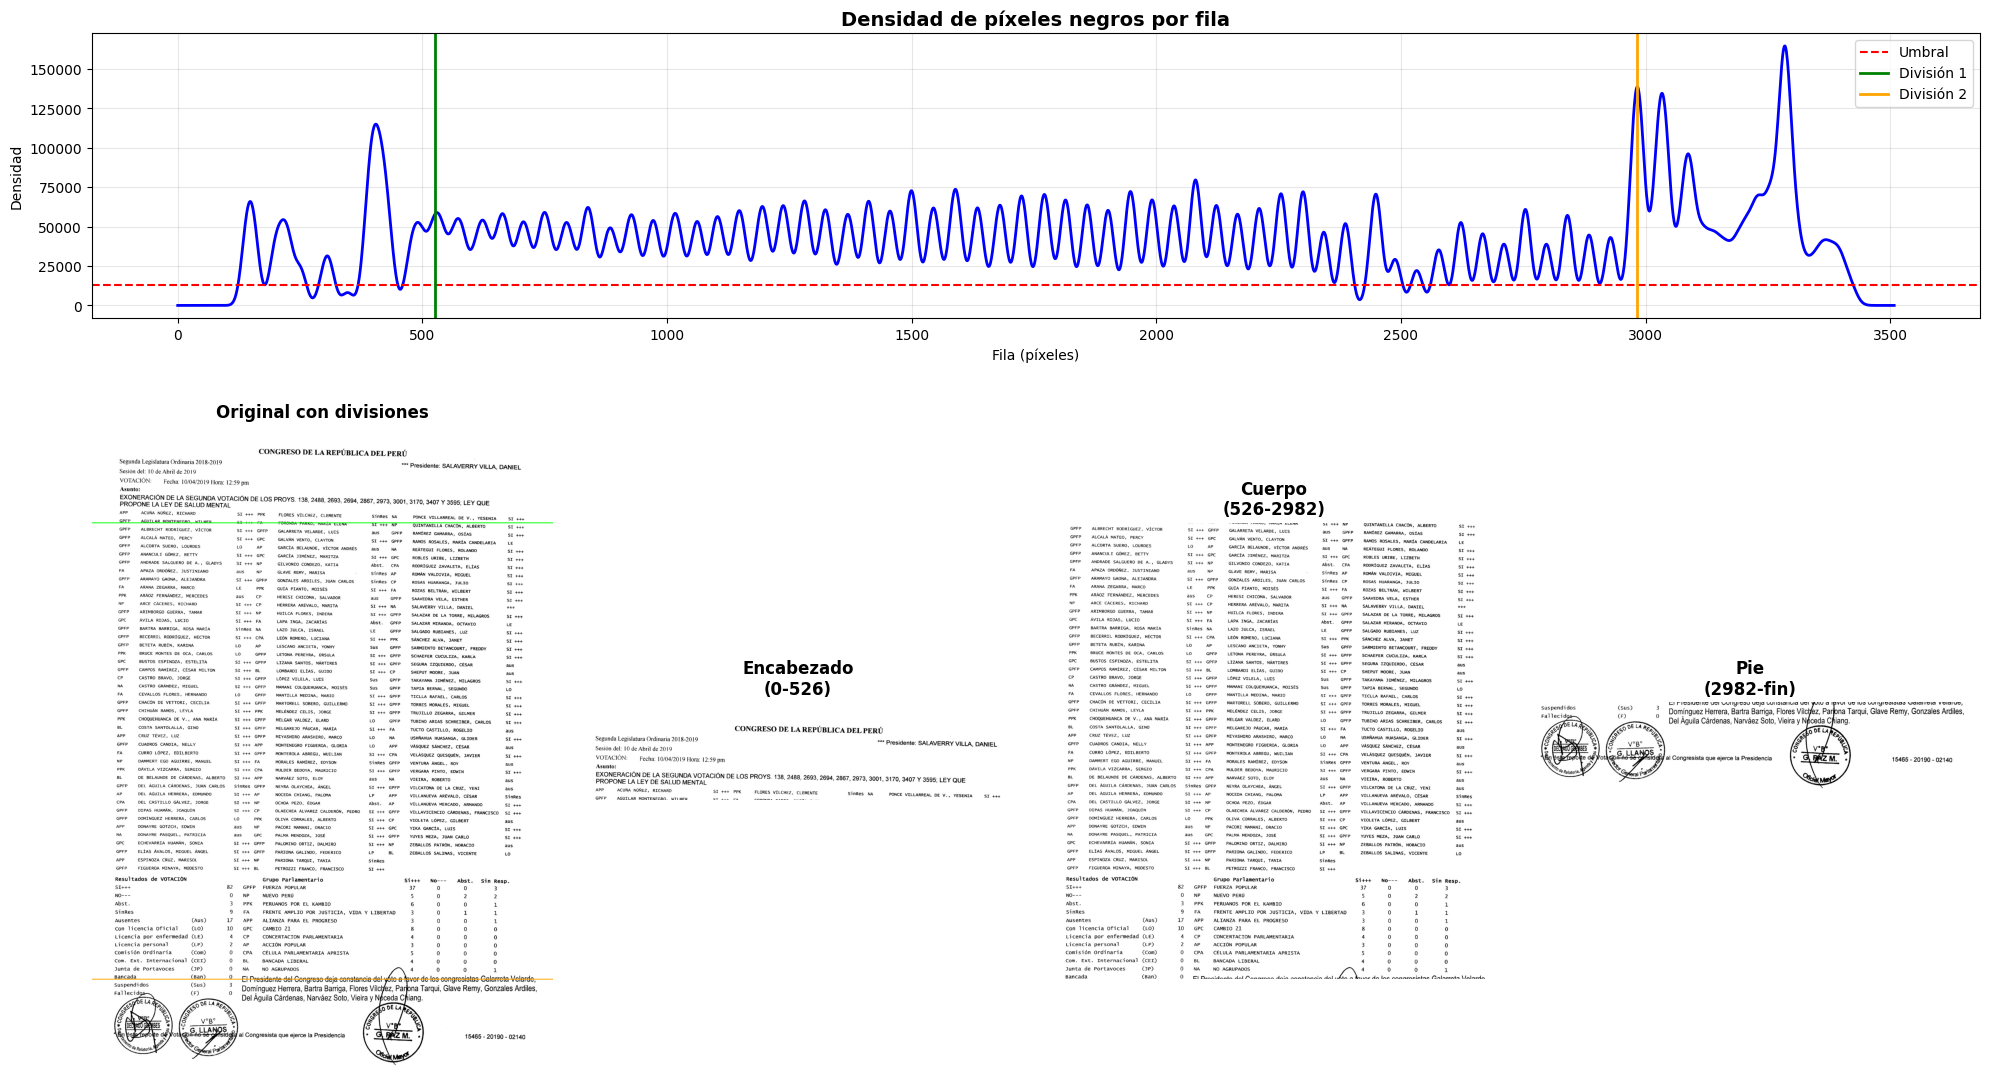

{'encabezado': array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255,

In [5]:
# ========================================
# PRUEBA RÁPIDA
# ========================================

ruta_imagen = '../data/c_comprimidos/430_pp2016_2021_pa2018_2019_leg2_page_14.jpg'

visualizar_division_densidad(ruta_imagen)


MÉTODO 2: División por detección de texto
'Asunto' encontrado en y=333
'Resultados' encontrado en y=2431


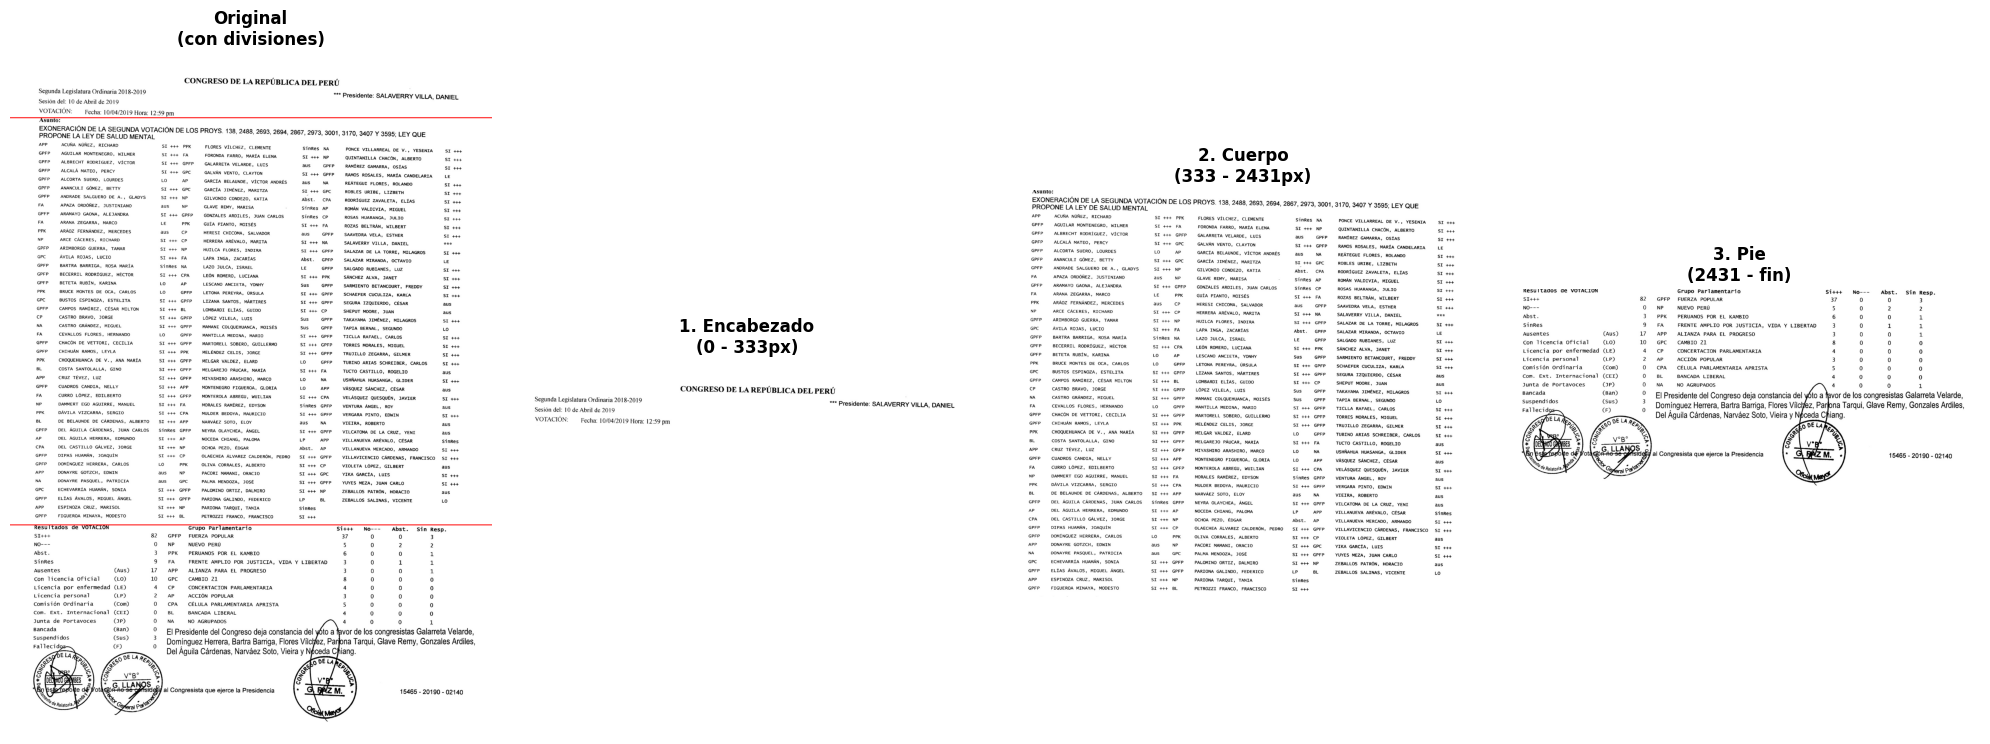

In [3]:
# ========================================
# PRUEBA RÁPIDA
# ========================================

ruta_imagen = '../data/c_comprimidos/430_pp2016_2021_pa2018_2019_leg2_page_14.jpg'

print("\n" + "=" * 60)
print("MÉTODO 2: División por detección de texto")
print("=" * 60)
palabras_clave = {
    'fin_encabezado': 'Asunto',
    'fin_cuerpo': 'Resultados'
}
partes_ocr = visualizar_division(ruta_imagen, palabras_clave)

In [ ]:
ruta_imagen = '../data/c_comprimidos/430_pp2016_2021_pa2018_2019_leg2_page_14.jpg'
